In [ ]:
# default_exp trainers
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
from FRED.trainers import *
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cuda


# 04 Flow Embedder Trainers
> Wrappers to train different variants of FRED, while producing bespoke visualizations. Useful for comparing multiple models, and also training en masse, e.g. on clusters

The `ManifoldFlowEmbedder` and `GraphFlowEmbedder` models in `FRED.embed` have all of the machinery to run the forward pass and compute the loss. But the training machinery -- backpropogation, gradient descent, weight adjustments, training visualizations, and early stopping -- are separated into their own networks, the friendly `Trainer`s!

This notebook introduces the `Trainer` base class, with all of the barebones machinery for training FRED. Later notebooks in the series will develop specialized trainers that use specific weighting regimes combined with visualizations customized to the regime.

In [ ]:
# export
import torch.nn as nn
import torch
import time
import datetime
import FRED
from tqdm.notebook import tqdm, trange
import glob
from PIL import Image
import os
from FRED.embed import ManifoldFlowEmbedder
import ipywidgets as widgets
import base64
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Trainer(object):
    def __init__(
        self,
        FE,
        loss_weights,
        title,
        visualization_functions,
        data_type = "Flow Neighbor",
        device=device,
        scheduler = None,
        learning_rate = 1e-3,
    ):
        self.vizfiz = visualization_functions
        self.loss_weights = loss_weights
        self.FE = FE.to(device)
        self.losses = None
        self.data_type = data_type
        self.title = title
        self.epochs_between_visualization = 1
        self.timestamp = datetime.datetime.now().isoformat().replace(":",".")
        if not os.path.exists("visualizations"):
            os.mkdir("visualizations")
        os.mkdir(f"visualizations/{self.timestamp}")
        self.optim = torch.optim.Adam(self.FE.parameters(), lr = learning_rate)
        self.scheduler = scheduler
        self.device = device

    def fit(self, dataloader, n_epochs=100):
        # for plotting
        self.dataloader = dataloader
        self.labels = dataloader.dataset.labels
        self.X = dataloader.dataset.X
        for epoch_num in trange(n_epochs):
            for data in self.dataloader:
                self.optim.zero_grad()
                # update loss weights according to scheduling
                if self.scheduler is not None:
                    self.loss_weights = self.scheduler(self.loss_weights)
                # have model compute losses, compile them into cost using loss weights
                if self.data_type == "Flow Neighbor":
                    data['X'] = data['X'].to(self.device)
                    data['P'] = data['P'].to(self.device)
                    data['precomputed distances'] = data['precomputed distances'].to(self.device)
                elif self.data_type == "Flow Prediction":
                    data['X'] = data['X'].to(self.device)
                    data['transition_to'] = data['transition_to'].to(self.device)
                    data['distance'] = data["distance"].to(self.device)
                losses = self.FE(data, self.loss_weights)
                cost = self.weight_losses(losses)
                # backpropogate and update model
                cost.backward()
                self.optim.step()
                # add losses to running loss history
                self.losses = collate_loss(
                    provided_losses=losses, weights = self.loss_weights, prior_losses=self.losses, 
                )
            # run visualizations, if needed
            if epoch_num % self.epochs_between_visualization == 0:
                title = f"{self.timestamp}/{self.title} Epoch {epoch_num:03d}"
                emb_X = self.FE.embedder(self.X.to(self.device))
                flowArtist = self.FE.flowArtist
                self.visualize(emb_X, flowArtist, self.losses, title)
        # Save most recent embedded points and flow artist for running visualizations
        self.embedded_points = self.FE.embedder(self.dataloader.dataset.X.to(self.device))
        self.flow_artist = flowArtist
        self.labels = self.dataloader.dataset.labels

    def weight_losses(self, losses):
        cost = 0
        for loss_name in losses.keys():
            cost += self.loss_weights[loss_name] * losses[loss_name]
        return cost

    def visualize(self, embedded_points, flow_artist, losses, title):
        for viz_f in self.vizfiz:
            viz_f(
                embedded_points=embedded_points,
                flow_artist=flow_artist,
                losses=losses,
                title=title,
                labels=self.labels,
                FE=self.FE,
            )

    def training_gif(self, duration=50):
        file_names = glob.glob(f"visualizations/{self.timestamp}/*.jpg")
        file_names.sort()
        frames = [Image.open(image) for image in file_names]
        frame_one = frames[0]
        frame_one.save(
            f"visualizations/{self.timestamp}/{self.title}.gif",
            format="GIF",
            append_images=frames,
            save_all=True,
            duration=duration,
            loop=0,
        )
        # display in jupyter notebook
        b64 = base64.b64encode(
            open(f"visualizations/{self.timestamp}/{self.title}.gif", "rb").read()
        ).decode("ascii")
        display(widgets.HTML(f'<img src="data:image/gif;base64,{b64}" />'))

    def visualize_embedding(self):
        visualize_points(
            embedded_points=self.embedded_points,
            flow_artist=self.flow_artist,
            labels=self.labels,
            title=self.title,
        )

    def visualize_loss(self, loss_type="all"):
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(self.losses[key])
            plt.legend(self.losses.keys(), loc="upper right")
            plt.title("loss")
        else:
            plt.plot(self.losses[loss_type])
            plt.title(loss_type)

ImportError: cannot import name 'bsr_array' from 'scipy.sparse' (/gpfs/gibbs/project/krishnaswamy_smita/kjm76/conda_envs/FREDkernel/lib/python3.9/site-packages/scipy/sparse/__init__.py)

# Testing the Trainer

Set sigma =  0.06195365


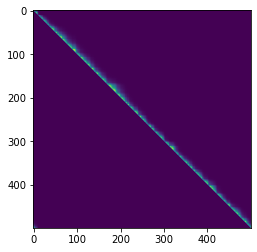

In [ ]:
from FRED.datasets import directed_circle
from FRED.data_processing import dataloader_from_ndarray
X, flow, labels = directed_circle()
# build dataset
dataloader = dataloader_from_ndarray(X,flow,labels)

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 1,
            "diffusion map regularization": 1,
            "flow neighbor loss": 1e-3,
            "smoothness": 0,
        }

In [ ]:
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, dataloader=dataloader, device=device, title="Hello FRED")

  0%|          | 0/100 [00:00<?, ?it/s]

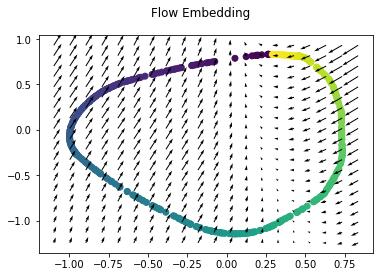

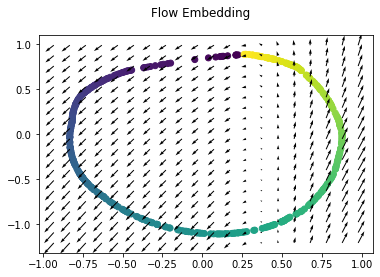

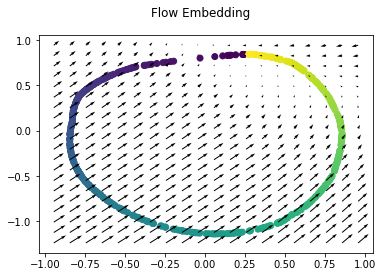

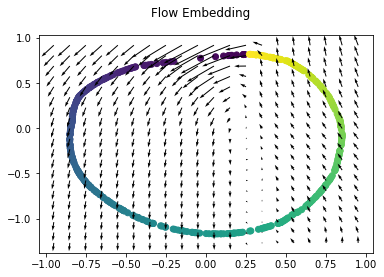

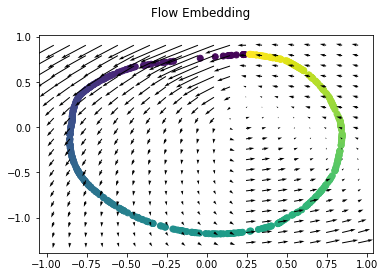

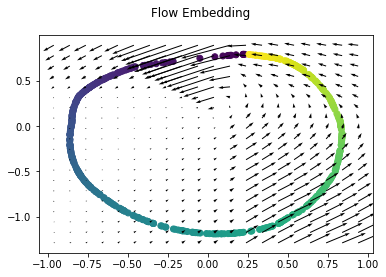

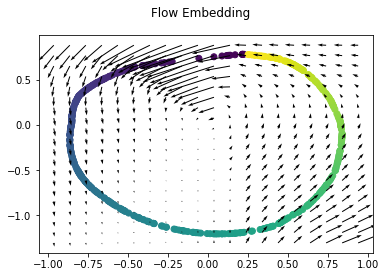

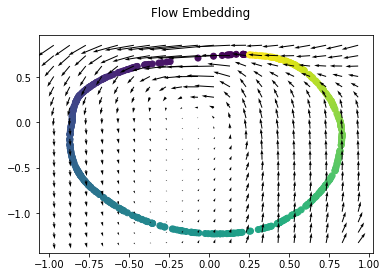

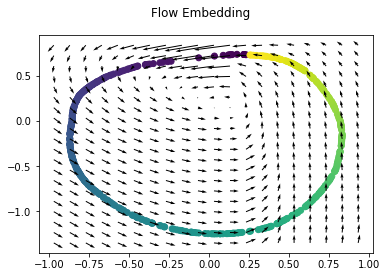

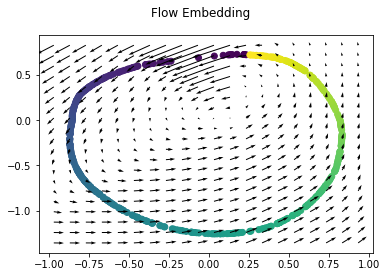

In [ ]:
FREDtrainer.fit()

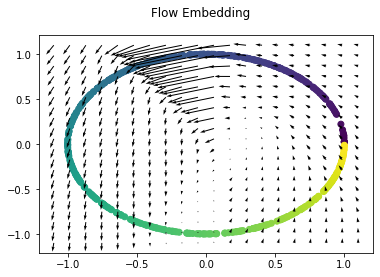

In [ ]:
FREDtrainer.visualize_embedding()

In [ ]:
FREDtrainer.training_gif()

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP///////f//+///+v//9///9P//5f7///z///v///n///7//P…